In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

seed = 69

torch.manual_seed(seed)
np.random.seed(seed)

In [2]:
class MnistDataset(Dataset):
    def __init__(self, csv_file, transform=None, train=True):
        '''
        Args:
            csv_file (string)
            transform (callable, optional)
        '''
        
        self.mnist = pd.read_csv(csv_file)
        self.train = train
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
    


        
        if self.train:
            img = self.mnist.iloc[idx].values[1:]
            img = np.reshape(img, (28,28))
            img = img / 255
            img = Image.fromarray(img)      
            
            label = self.mnist.iloc[idx][0]
            label = np.array(label)
            
            if self.transform:
                img = self.transform(img)
                
            sample = {"label": torch.from_numpy(label), "image":img}
                
        else:
            
            img = self.mnist.iloc[idx].values[0:]
            img = np.reshape(img, (28,28))
            img = img / 255
            img = Image.fromarray(img)      
            
            if self.transform:
                img = self.transform(img)
                
            sample = {"image": img}
             
        return sample

class ToTensor(object):
    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        return {'image': torch.from_numpy(image),
                'label': torch.from_numpy(label)}

In [3]:
training_split = 0.8
batch_size = 64

mnist_train_dataset = MnistDataset("mnist/train.csv", transform=transforms.Compose([
                                                                                    transforms.RandomRotation(2.8),
                                                                                    transforms.ToTensor(),
                                                                                    transforms.Normalize((0.130,), (0.3081)),
                                                                                     ]))
mnist_test_dataset = MnistDataset("mnist/test.csv", train=False, transform=transforms.Compose([
                                                                                    transforms.ToTensor(),
                                                                                    transforms.Normalize((0.130,), (0.3081)),
                                                                                     ]))

train_length = int(training_split * len(mnist_train_dataset))
validation_length = len(mnist_train_dataset) - train_length

train_dataset, validation_dataset = torch.utils.data.random_split(mnist_train_dataset, (train_length, validation_length))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(mnist_test_dataset, batch_size=1, shuffle=False)

..\torch\csrc\utils\tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


<Figure size 432x288 with 0 Axes>

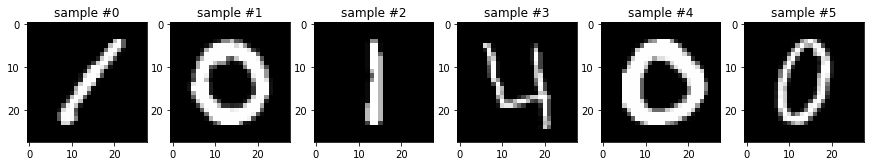

In [4]:
imgs_ = 6
fig = plt.figure()
plt.figure(figsize=(15,imgs_))
for i in range(imgs_):
    ax = plt.subplot(1, imgs_, i+1)
    ax.set_title('sample #{}'.format(i))
    plt.imshow(np.reshape(mnist_train_dataset[i]["image"], (28,28)), cmap='gray')
    
plt.show()

In [8]:
learning_rate = 0.01

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

model = CNN().to(device)
optimizer = optim.Adadelta(model.parameters(), lr=learning_rate)
# scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
criterion = nn.CrossEntropyLoss()

In [6]:
def train(epoch, loader, log_interval=500):
    # Set model to training mode
    model.train()
    
    # Loop over each batch from the training set
    for batch_idx, data in enumerate(train_loader):
        
        variables = data["image"].to(device)
        target = data["label"].to(device)

        # Zero gradient buffers
        optimizer.zero_grad() 
        
        # Pass data through the network
        output = model(variables)
        # Calculate loss
        loss = F.nll_loss(output, target)

        # Backpropagate
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))

def validate(loss, accuracy_list, loader):
    model.eval()
    val_loss, correct = 0, 0
    
    for data in loader:
        variables = data["image"].to(device)
        target = data["label"].to(device)
        
        
        output = model(variables)
        val_loss += F.nll_loss(output, target, reduction='sum').item()
        
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    val_loss /= len(loader)
    loss.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(loader.dataset)
    accuracy_list.append(accuracy)
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(loader.dataset), accuracy))

In [9]:
epochs = 30

loss_, acc_ = [], []
for epoch in range(1, epochs + 1):
    train(epoch, train_loader)
    validate(loss_, acc_ , validation_loader)

Train Epoch: 1 [0/33600 (0%)]	Loss: 2.290919
Train Epoch: 1 [32000/33600 (95%)]	Loss: 0.524444

Validation set: Average loss: 25.1388, Accuracy: 7447/8400 (89%)

Train Epoch: 2 [0/33600 (0%)]	Loss: 0.526603
Train Epoch: 2 [32000/33600 (95%)]	Loss: 0.539616

Validation set: Average loss: 18.9402, Accuracy: 7644/8400 (91%)

Train Epoch: 3 [0/33600 (0%)]	Loss: 0.291765
Train Epoch: 3 [32000/33600 (95%)]	Loss: 0.228504

Validation set: Average loss: 15.9646, Accuracy: 7776/8400 (93%)

Train Epoch: 4 [0/33600 (0%)]	Loss: 0.370696
Train Epoch: 4 [32000/33600 (95%)]	Loss: 0.412896

Validation set: Average loss: 14.0211, Accuracy: 7839/8400 (93%)

Train Epoch: 5 [0/33600 (0%)]	Loss: 0.282870
Train Epoch: 5 [32000/33600 (95%)]	Loss: 0.225410

Validation set: Average loss: 12.6790, Accuracy: 7884/8400 (94%)

Train Epoch: 6 [0/33600 (0%)]	Loss: 0.225772
Train Epoch: 6 [32000/33600 (95%)]	Loss: 0.323807

Validation set: Average loss: 11.6120, Accuracy: 7935/8400 (94%)

Train Epoch: 7 [0/33600 (0%)

# Running on test set

In [10]:
model.eval()
output_list = []
for idx, data in enumerate(test_loader):
    output = model(data["image"].float().to(device))
    output_list.append([idx+1, (output.data.max(1)[1].cpu().numpy().tolist()[0])])

In [11]:
len(output_list) == len(mnist_test_dataset)


True

In [12]:
#export to csv
pd.DataFrame(output_list, columns=["ImageId", "Label"]).to_csv("predictions_cnn.csv", index=False)